## Prepare imports

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.data import Batch,Data


DEVICE = "cuda:0"
ECT_PLOT_CONFIG = {"cmap":"bone","vmin":-0.5,"vmax":1.5}
PC_PLOT_CONFIG = {"s":10,"c":'.5'}


## Load Models and Data

In [15]:
from types import SimpleNamespace
from datasets import load_datamodule
import yaml
import json

from models.encoder import BaseModel as Encoder


def load_object(dct):
    return SimpleNamespace(**dct)

with open("./configs/config_encoder_mnist.yaml", encoding="utf-8") as stream:
    run_dict = yaml.safe_load(stream)
    encoder_config = json.loads(json.dumps(run_dict), object_hook=load_object)

dm = load_datamodule(encoder_config.data)


encoder = Encoder.load_from_checkpoint(f"./trained_models/{encoder_config.modelconfig.save_name}")



C:\Users\ernst\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.3.3, which is newer than your current Lightning version: v2.2.3


In [16]:
data_list = []
for idx in range(10):
    data_list.extend(dm.test_ds[dm.test_ds.y==idx][:1])

batch = Batch.from_data_list(data_list).to(DEVICE)

In [17]:
ect = encoder.layer(batch,batch.batch).unsqueeze(1)
print(ect.min())
print(ect.max())

tensor(0., device='cuda:0')
tensor(1., device='cuda:0')


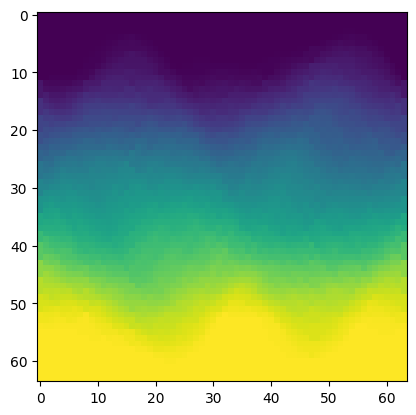

In [18]:
plt.imshow(ect[0].cpu().squeeze())

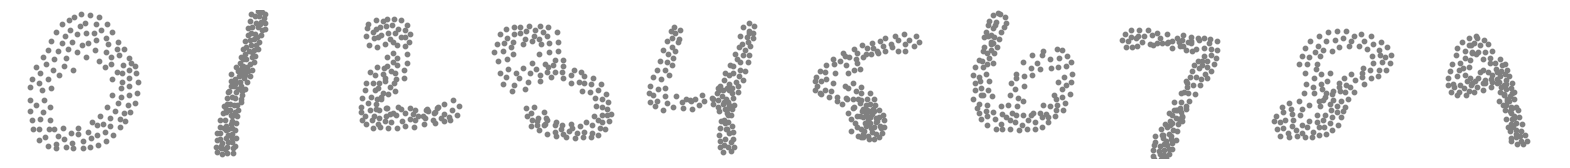

In [23]:
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)


with torch.no_grad():
    recon_batch = encoder.model(ect.squeeze())

fig, axes = plt.subplots(
    nrows=1, ncols=10, figsize=(20,8)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)
    
for orig_pts, recon_pts,axis in zip(batch.x.view(-1,128,2),recon_batch,axes.T):
    # print(recon_pts_x.shape)
    recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
    orig_pts = orig_pts.view(-1,2).cpu().detach().squeeze().numpy()
   
    orig_pts = rotate(orig_pts, degrees=-90)
    recon_pts = rotate(recon_pts, degrees=-90)
    
    ax = axis
    ax.scatter(recon_pts[:,0],recon_pts[:,1],**PC_PLOT_CONFIG)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_aspect(1)
    ax.axis("off")
